<img align='left' alt='ESO Logo' src='http://archive.eso.org/i/esologo.png'>  

# &nbsp; ESO Science Archive Programmatic: HOWTOs

## HOW TO obtain catalogue data collected with ESO-VISTA 

Catalogues produced by PIs of ESO observing programmes are integrated into the ESO science archive through the [Phase 3 process](https://www.eso.org/sci/observing/phase3.html) and are accessible either via the [ESO Archive Science Portal](https://archive.eso.org/scienceportal/home?dp_type=CATALOG&sort=-obs_date), or via the [Catalog Facility](https://www.eso.org/qi/), or [programmatically](http://archive.eso.org/programmatic/#TAP?e=1) via the `tap_cat` service.

In the following, we will show how to collect catalogue entries associated with the [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). This will be done by exploiting the `archive_catalogues` module part of the [ESOAsg](https://esoasg.readthedocs.io/en/latest/) `python` repository. This is a wrapper around the [_programmatic access_](http://archive.eso.org/programmatic/#TAP) that allows users to embed [Virtual Observatory Table Access Protocol (TAP)](https://www.ivoa.net/documents/TAP/20190927/) queries within their `python` environment. 

In [ ]:
from ESOAsg import archive_catalogues # ESO Archive Catalogue

from astropy.coordinates import SkyCoord # Astropy coordinates
from astropy.io import fits # Astropy FITS files
import astropy.constants as const # Astropy constants
import astropy.units as u # Astropy units
import matplotlib.pyplot as plt # Matplotlib
import numpy as np # Numpy
import scipy as sp # Scipy

# Set the default font size and weight for plots
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['xtick.minor.visible'] = True
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['ytick.right'] = True
plt.rcParams['ytick.minor.visible'] = True
plt.rcParams['figure.dpi'] = 200

---
## <a id='Check catalogue'>1. Check the catalogue you want to query </a>

The full list of available scientific catalogues could be found [here](https://www.eso.org/qi/). Alternatively, this information can retrived by using:
```python
archive_catalogues.all_catalogues_info(all_versions=True)
```
This will return an astropy table of all catalogues (and all their versions). Note that the column `last_version` highlights with `False` and obsolete catalogues for which a newer version is present. 

It is however possible to remove these obsolete versions by setting:
```python
all_version=False # i.e. the default behavior
```

In [ ]:
all_catalogues = archive_catalogues.catalogues_info(all_versions=False)

Now `all_catalogues` contains information on all the latest versions of the catalogues currently present at ESO:

In [ ]:
all_catalogues['collection', 'table_name', 'title', 'version', 'instrument', 'telescope'].show_in_notebook(show_row_index=False, display_length=5)

### <a id='Check catalogue'>1.1 Get catalogues </a>

Given that `all_catalogues` is a `Table` you can create a filter based on the `telescope` column. Possible values are:

In [ ]:
print('Possible values for the telescope entry: \n {}'.format(np.unique(all_catalogues['telescope']).tolist()))

You can now select all the `ESO-VISTA` catalogues applying a filter for 'ESO-VISTA' and 'ESO-VST, ESO-VISTA' to the `all_catalogues` table:

In [ ]:
vista_telescope_filter = (all_catalogues['telescope'] == 'ESO-VISTA') | (all_catalogues['telescope'] == 'ESO-VST, ESO-VISTA')
vista_catalogues = all_catalogues.copy()[vista_telescope_filter]
vista_catalogues['collection', 'table_name', 'title', 'version', 'instrument', 'telescope'].show_in_notebook(show_row_index=False, display_length=5)

To obtain the description of the content of each of the selected tables, you can recursively loop over the entries of the `description` column:

In [ ]:
# for idx in range(len(vista_catalogues)):
for idx in range(2):
    print('Collection:  {} \nTable:       {} \nDescription: {} \n \n'.format(vista_catalogues['collection'][idx],
                                                                       vista_catalogues['table_name'][idx],
                                                                       vista_catalogues['description'][idx]))

### <a id='Get RA/Dec'>1.2 Identify RA, Dec (or other properties) in catalogues</a>

Now you are ready the recursively explore all catalogues containing data collected with the [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). There is however a point that needs to be taken into account first: some catalogues can be spread among different tables. 

This is the case, for instance, of the [VISTA survey of the Magellanic Clouds system (VMC)](https://www.eso.org/rm/api/v1/public/releaseDescriptions/155). 

The reference catalogue that contains position and ID of the sources is identified by the column `target_table`:

In [ ]:
vmc_filter = (vista_catalogues['collection'] == 'VMC')
vmc_catalogues = vista_catalogues.copy()[vmc_filter]
vmc_catalogues['collection', 'table_name', 'target_table', 'table_RA', 'table_Dec'].show_in_notebook(show_row_index=False, display_length=5)

This basically means, for instance, that basic information on the targets present in the table `vmc_dr6_ksjy_V5` are located in the `target_table`: `vmc_dr6_ksjy_V5`. Thus to find RA and Dec of the sources present in the [VMC](https://www.eso.org/rm/api/v1/public/releaseDescriptions/155) catalogues, you should (in principle) extract columns corresponding to the the `ucd` tokes: `pos.eq.ra;meta.main` and `pos.eq.dec;meta.main` from the `target_table`:

In [ ]:
columns_VMC_PhotJ = archive_catalogues.columns_info(tables='vmc_dr6_ksjy_V5')
columns_VMC_PhotJ[(columns_VMC_PhotJ['ucd'] == 'pos.eq.ra;meta.main') | 
                  (columns_VMC_PhotJ['ucd'] == 'pos.eq.dec;meta.main') ].show_in_notebook(show_row_index=False)

Or equivalently, by extracting from the `vista_catalogues` table entries of the column `table_RA` and `table_Dec` correspoding to the `target_table` = `vmc_dr6_ksjy_V5`:

In [ ]:
filter_target_table_vmc = (vmc_catalogues['table_name'] == 'vmc_dr6_ksjy_V5')
column_RA, column_Dec = vmc_catalogues[filter_target_table_vmc]['table_RA'][0], vmc_catalogues[filter_target_table_vmc]['table_Dec'][0]
print('The columns containing RA and Dec in vmc_dr6_ksjy_V5 are:\n{}, {}'.format(column_RA, column_Dec))

### <a id='Explore Catalogues'>1.3 Explore content of the catalogues </a>


In general, one can glance the content of a catalogue by checking the name of the columns present in the associated list of tables (or list of collections). For instance, for the [Kilo Degree Survey](https://www.eso.org/rm/api/v1/public/releaseDescriptions/151) this can be obtained with calling:
```python
archive_catalogues.columns_info(tables='KiDS_DR4_1_ugriZYJHKs_cat_fits')
```

In [ ]:
table_kids = 'KiDS_DR4_1_ugriZYJHKs_cat_fits'
columns_kids = archive_catalogues.columns_info(tables=table_kids)
columns_kids.show_in_notebook(show_row_index=False, display_length=5)

Once you decided which columns you want to extract from a given table, you can get it using:
```python
archive_catalogues.get_catalogues(tables=table_name, columns=columns)
```
For instance, to obtain `MAG_AUTO` and `MAGERR_AUTO` from the `KIDS` table (note that for the moment with limit the query to only 5 entries, i.e. we set `maxrec=5`):

In [ ]:
columns = ['MAG_AUTO', 'MAGERR_AUTO']
kids = archive_catalogues.get_catalogues(tables=table_kids, columns=columns, maxrec=5)

The result is thus stored in an `astropy.table`:

---

## <a id='Plot Catalogues'>2. Show Location of sources observed with ESO-VISTA </a>


Now it is time to play with the catalogues...  

For instance you can plot the sky location of all sources detected with [ESO-VISTA telescope](https://www.eso.org/sci/facilities/paranal/telescopes/vista.html). Note that there can be a lot of sources, which can get heavy for both downloading and plotting so we limit the number of rows with `MAXREC` parameter.

In [88]:
# We limit the number of retrieved entries 
MAXREC = 5000000

print(f'The limit of {MAXREC} has been applied.')

The limit of 5000000 has been applied.


[INFO]    :: The query to VIDEO_CAT_DR5 returned 3260679 entries (with a limit set to maxrec=5000000)


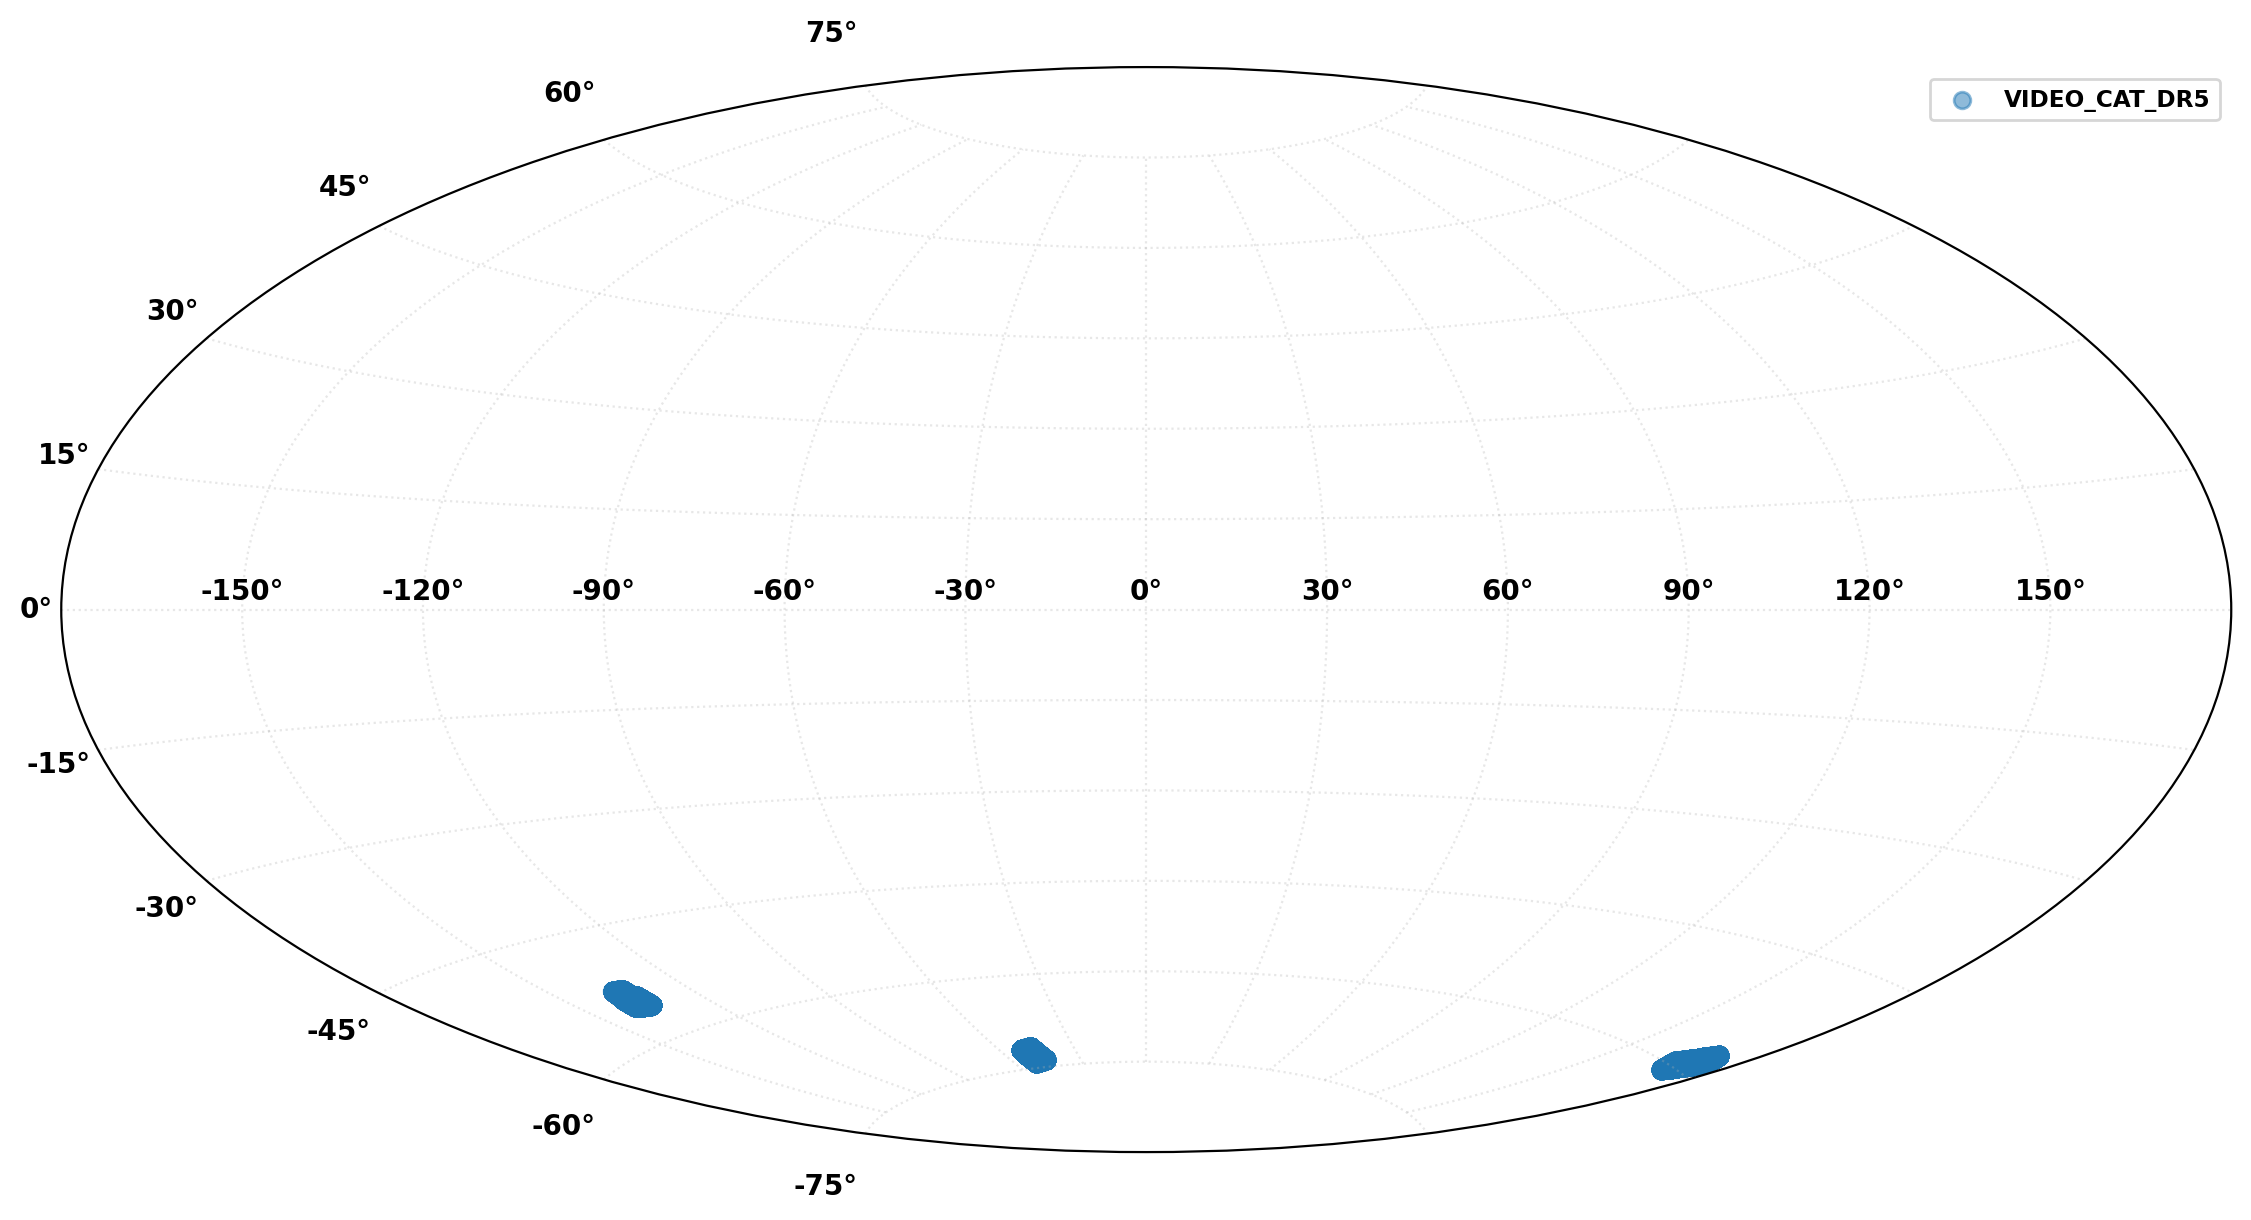

In [98]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='aitoff')

for idx in [10]:
# for idx in range(len(vista_catalogues)):
    table_name =  vista_catalogues['table_name'][idx]
    target_table =  vista_catalogues['target_table'][idx]

    if target_table == '':

        # Getting RA and Dec
        columns = archive_catalogues.columns_info(tables=table_name)
        columns_pos = [columns['column_name'][ (columns['ucd'] == 'pos.eq.ra;meta.main') ][0],
                       columns['column_name'][ (columns['ucd'] == 'pos.eq.dec;meta.main') ][0]]
        positions = archive_catalogues.get_catalogues(tables=table_name, columns=columns_pos, maxrec=MAXREC)

        # Converting RA and Dec in SkyCoord object and taking care of the `Degree` entries
        if not isinstance(positions[columns_pos[0]].unit, u.core.Unit):
            positions[columns_pos[0]].unit = u.deg
            positions[columns_pos[1]].unit = u.deg
        sky_positions = SkyCoord(positions[columns_pos[0]].data*positions[columns_pos[0]].unit, 
                                 positions[columns_pos[1]].data*positions[columns_pos[1]].unit).galactic
        ax.scatter(sky_positions.l.wrap_at('180d').radian, sky_positions.b.radian, alpha=0.5,
                    label=table_name)
        
ax.legend(fontsize='small', loc='upper right')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/vista_catalogues.png', format='png', bbox_inches='tight')

[INFO]    :: The query to VIDEO_CAT_DR5 returned 3260679 entries (with a limit set to maxrec=5000000)
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


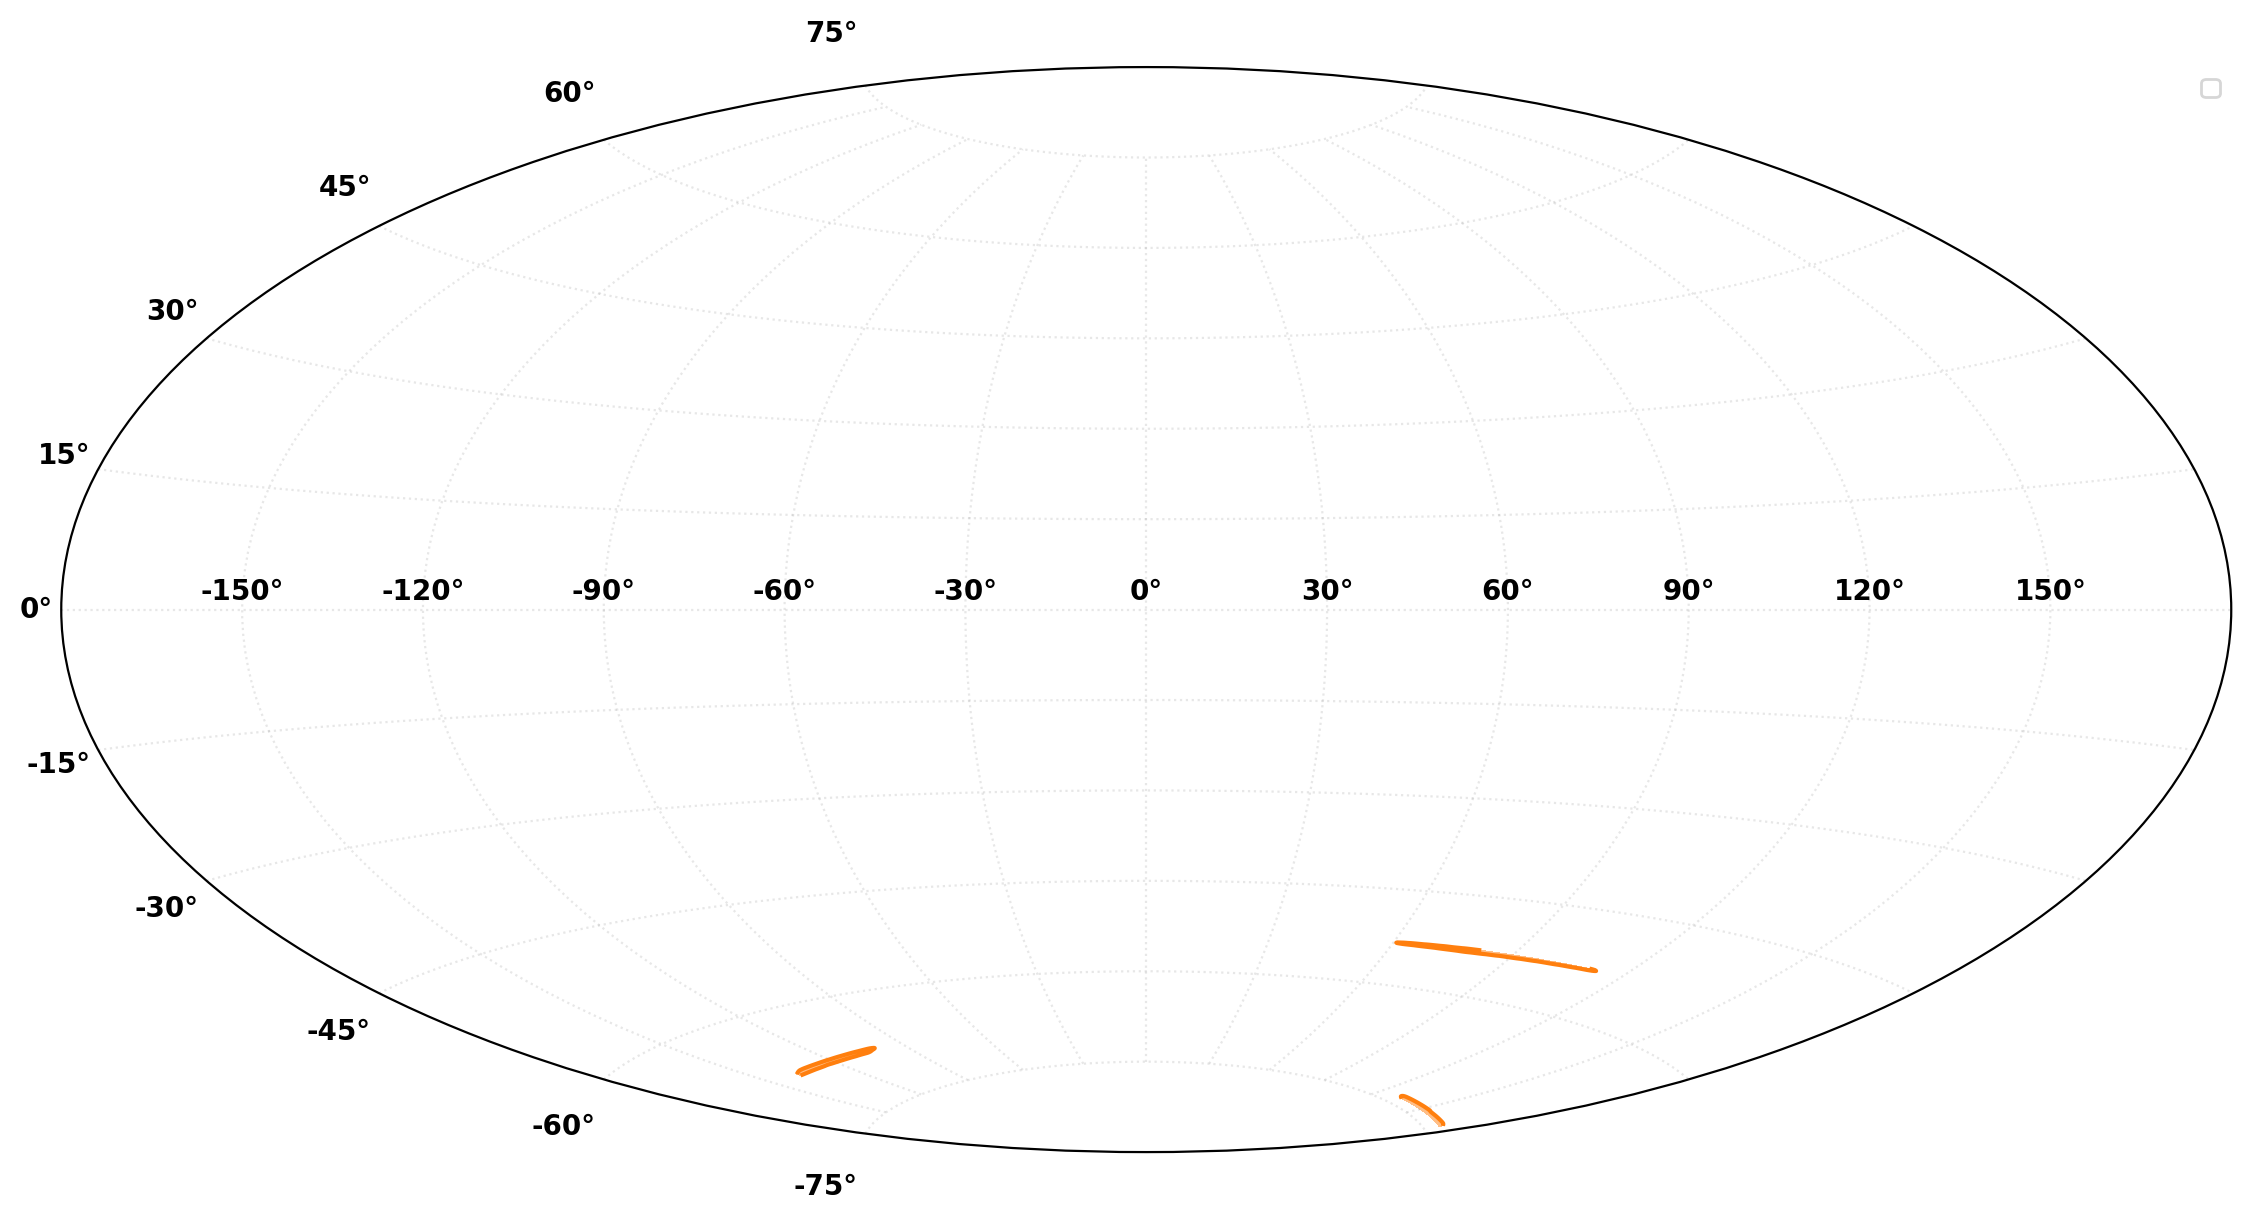

In [93]:
import scipy.stats as stats # Scipy Stats

# Define a function to perform and plot contours
def plot_contours(ax, x, y, colors='C1', sigma=[1, 1]):
    """
    Generate contours on the provided axes.

    Parameters:
        ax: Matplotlib axis to plot on.
        x, y: Data for the contours (1D arrays).
        colors: Colors for filled contours.

    Returns:
        ax: Matplotlib axis with contours plotted.
    """

    hist = list(np.histogram2d(x, y, bins=500)) # Compute the 2D histogram
    hist[0] = hist[0] / np.max(hist[0]) # Normalize the histogram for consistent contour levels
    hist[0] = sp.ndimage.gaussian_filter(hist[0], sigma, mode='reflect') # Apply a Gaussian filter to the histogram

    ax.contour(hist[1][:-1], hist[2][:-1], hist[0], colors=colors, levels=[0.01, 1])
    ax.contourf(hist[1][:-1], hist[2][:-1], hist[0], colors=colors, levels=[0.01, 1], alpha=0.5)

    return ax

fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='aitoff')

for idx in [10]:
# for idx in range(len(vista_catalogues)):
    table_name =  vista_catalogues['table_name'][idx]
    target_table =  vista_catalogues['target_table'][idx]

    if target_table == '':

        # Getting RA and Dec
        columns = archive_catalogues.columns_info(tables=table_name)
        columns_pos = [columns['column_name'][ (columns['ucd'] == 'pos.eq.ra;meta.main') ][0],
                       columns['column_name'][ (columns['ucd'] == 'pos.eq.dec;meta.main') ][0]]
        positions = archive_catalogues.get_catalogues(tables=table_name, columns=columns_pos, maxrec=MAXREC)

        # Converting RA and Dec in SkyCoord object and taking care of the `Degree` entries
        if not isinstance(positions[columns_pos[0]].unit, u.core.Unit):
            positions[columns_pos[0]].unit = u.deg
            positions[columns_pos[1]].unit = u.deg
        sky_positions = SkyCoord(positions[columns_pos[0]].data*positions[columns_pos[0]].unit, 
                                 positions[columns_pos[1]].data*positions[columns_pos[1]].unit).galactic
        
        # ax.scatter(sky_positions.l.wrap_at('180d').radian, sky_positions.b.radian, alpha=0.5,
        #             label=table_name)

        plot_contours(ax, sky_positions.l.wrap_at('180d').radian, sky_positions.b.radian)

ax.legend(fontsize='small', loc='upper right')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/vista_catalogues.png', format='png', bbox_inches='tight')

In [95]:
ax.imshow_hpx?

Object `ax.imshow_hpx` not found.


In [ ]:
x = np.random.normal(0, 0.5, 100000)
y = np.random.normal(0, 0.5, 100000)

# Create a grid for evaluating the KDE
xx, yy = np.mgrid[-np.pi:np.pi:200j, -np.pi/2:np.pi/2:200j]
positions = np.vstack([xx.ravel(), yy.ravel()])
values = np.vstack([x, y])

In [ ]:
# Perform KDE using scipy's gaussian_kde
kernel = stats.gaussian_kde(values)
kde = np.reshape(kernel(positions).T, xx.shape)
kde = kde / np.max(kde)  # Normalize the KDE for consistent contour levels

In [77]:
hist = list(np.histogram2d(x, y, bins=200))
hist[0] = hist[0] / np.max(hist[0])

In [78]:
import scipy as sp

sigma = [2, 2]
hist[0] = sp.ndimage.filters.gaussian_filter(hist[0], sigma, mode='constant')

/var/folders/3y/cmsgt3_x7x72bbs__zhy_q6h0008wr/T/ipykernel_19148/4241790407.py:4: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  hist[0] = sp.ndimage.filters.gaussian_filter(hist[0], sigma, mode='constant')


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


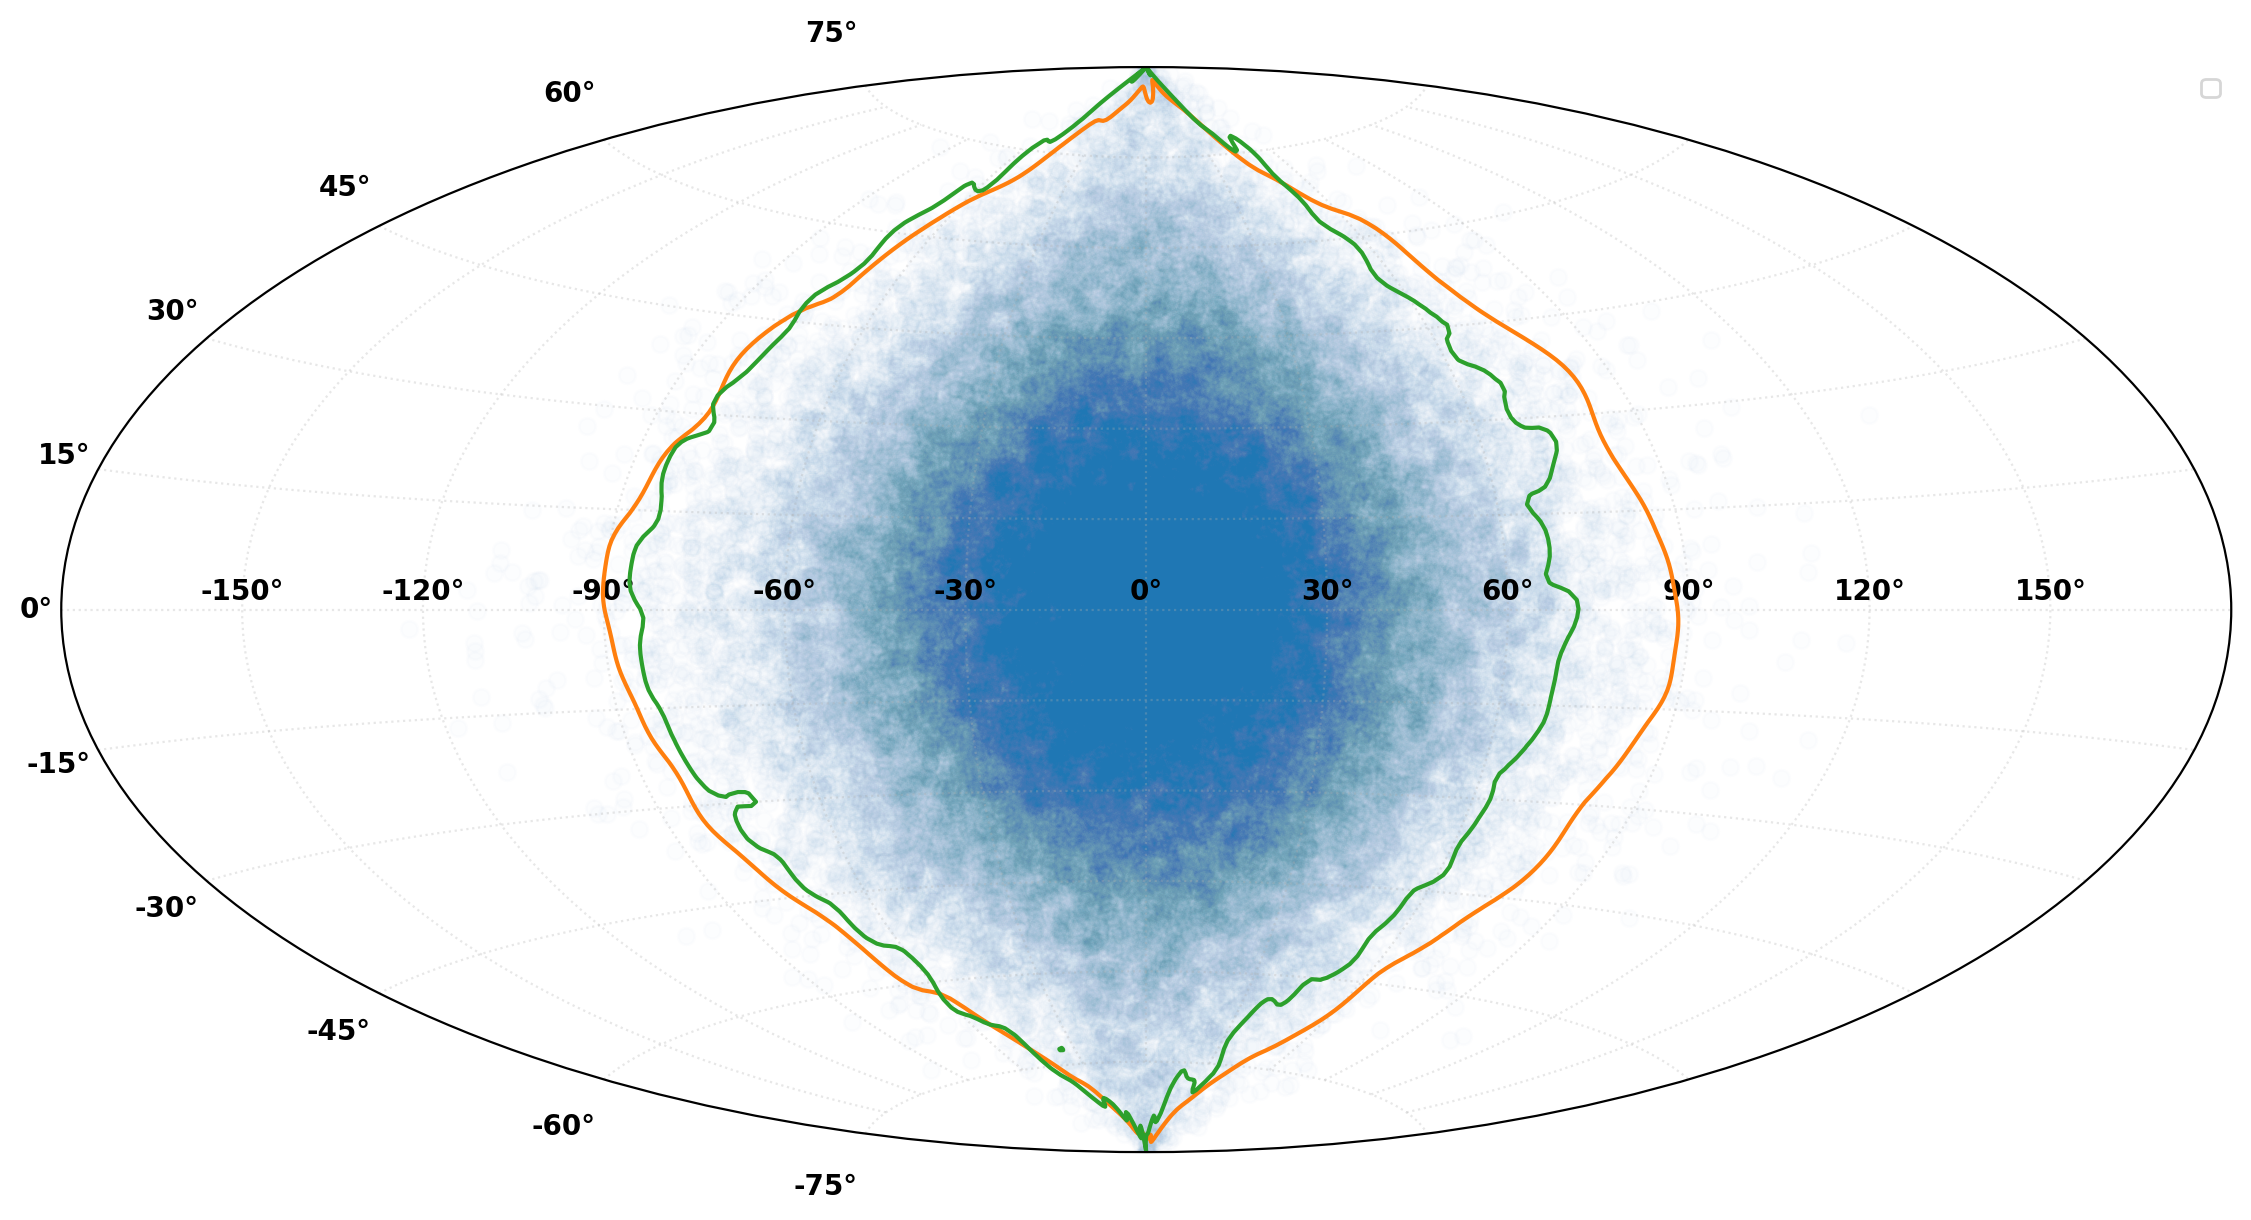

In [79]:
fig = plt.figure(figsize=(14,10))
ax = fig.add_subplot(111, projection='aitoff')

ax.scatter(x, y, alpha=0.01) 

ax.contour(xx, yy, kde, colors='C1', levels=[0.01,1])       
ax.contour(hist[1][:-1], hist[2][:-1], hist[0], colors='C2', levels=[0.01,1])

ax.legend(fontsize='small', loc='upper right')
ax.grid(True, ls=':', alpha=0.3)

fig.savefig('./figures/vista_catalogues.png', format='png', bbox_inches='tight')